# Connective fields in prfpy 

This illustrates a prfpy implementation of the connective field model fitting methods reported in the Knapen (PNAS 2020) paper.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Stage 1. define source region for CF models.

First, lets define a source region. Here we chose V1, but equally it could be A1, or M1. To do this, we first need to define where this ROI sits in each hemisphere.

In [9]:
import cortex
roi_verts = cortex.get_roi_verts('hcp_999999', 'V1',mask=True)

In [10]:
maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

Essentially, what we want is a boolean mask, that defines the location of the source region in each hemisphere. It will be false where the vertices are not in V1 and it will be True when the vertices are in V1.

In [11]:
maskL

array([False, False, False, ..., False, False, False])

## Stage 2. Create a sub-surface for the source region.

Now, we create a subsurface based on V1. The arguments for this are the name of the subject (who must be in the pycortex database) and the two masks that define the position of V1 in both hemispheres.

In [12]:
from prfpy.utils import subsurface
myv1surf=subsurface('hcp_999999',[maskL,maskR])

We use the 'create' method to generate this subsurface.

In [13]:
myv1surf.create()

Generating subsurfaces
Creating distance by distance matrices


This sub-surface object has a number of attributes. For instance, the *distance matrix* attribute is a matrix that defines the distance from all vertces in the subsurface to all other vertices in the sub-surface.

In [14]:
myv1surf.distance_matrix

array([[0.        , 1.24027392, 2.88532564, ...,        inf,        inf,
               inf],
       [0.71221074, 0.        , 1.60887214, ...,        inf,        inf,
               inf],
       [2.25014134, 1.30320888, 0.        , ...,        inf,        inf,
               inf],
       ...,
       [       inf,        inf,        inf, ..., 0.        , 0.98343155,
        1.88453612],
       [       inf,        inf,        inf, ..., 1.06412855, 0.        ,
        0.75200825],
       [       inf,        inf,        inf, ..., 2.10753158, 1.09422208,
        0.        ]])

Note that vertices in the opposite hemisphere are given infinite distance values, since we treat the hemispheres seperately.

We can also visualise our sub-surface by using the 'show' method.

In [15]:
myv1surf.subsurface_verts

array([   135,    136,    137, ..., 106259, 106260, 106261])

In [16]:
def basic_plot(dat,vmax,subject='fsaverage',vmin=0,rois=False,colorbar=False,cmap='plasma',ax=None):
    light=cortex.Vertex(dat,subject=subject, vmin=vmin, vmax=vmax,cmap=cmap)
    mfig=cortex.quickshow(light,with_curvature=True,with_rois=rois,with_colorbar=colorbar,fig=ax)
    
    
def alpha_plot(dat,dat2,vmax,subject='fsaverage',vmin=0,rois=False,colorbar=False,cmap='plasma_alpha',ax=None):
    light=cortex.Vertex2D(dat,dat2,subject=subject, vmin=vmin, vmax=vmax,vmin2=0,vmax2=np.nanmax(dat2),cmap=cmap)
    mfig=cortex.quickshow(light,with_curvature=True,with_rois=rois,with_colorbar=colorbar,fig=ax)

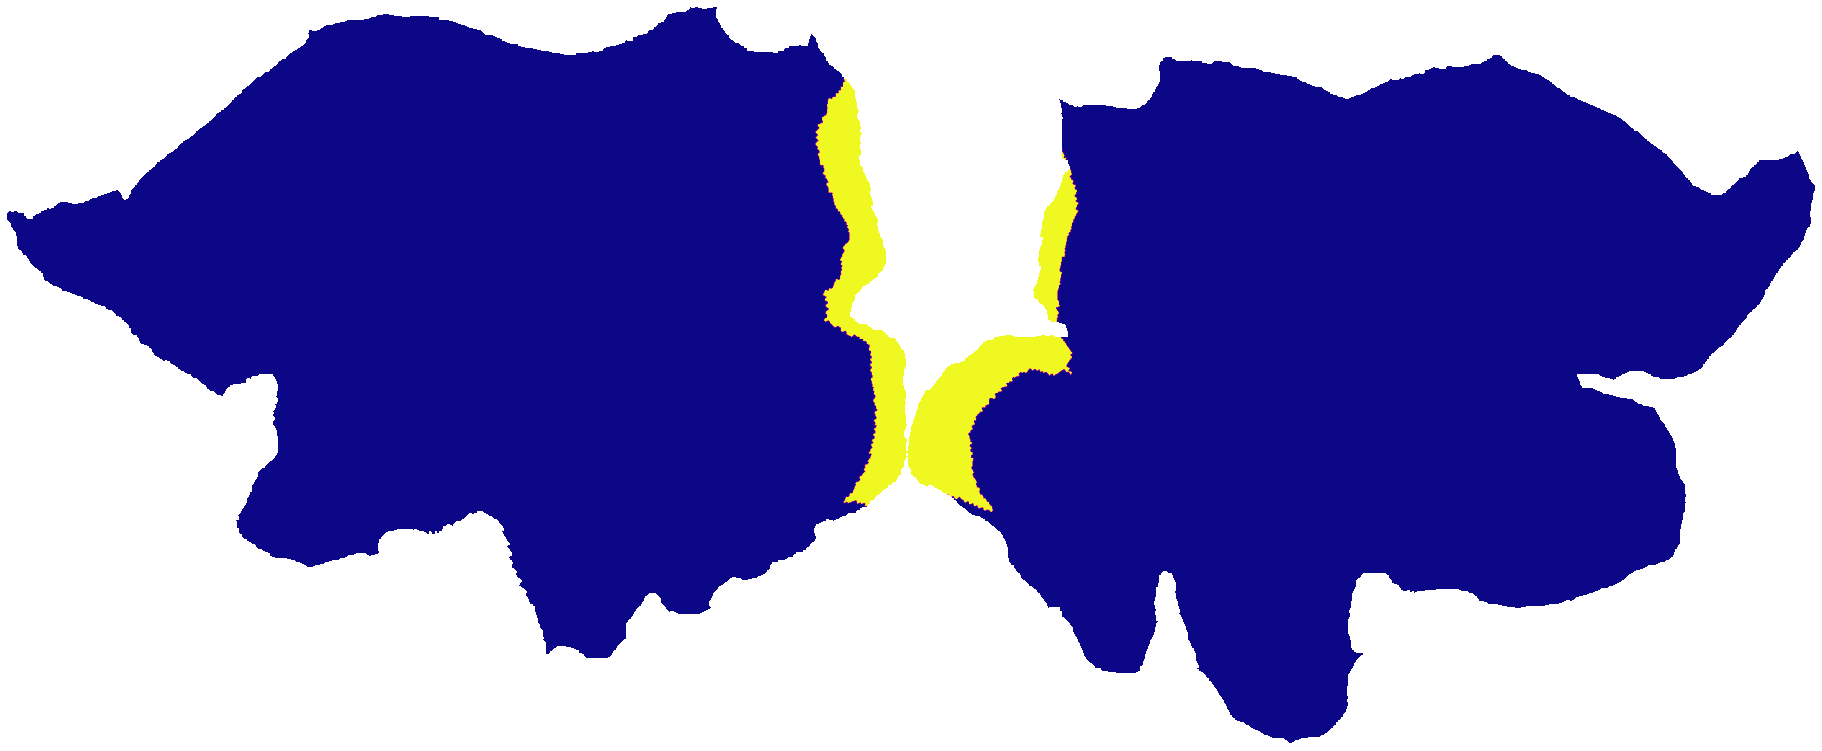

In [17]:
basic_plot(myv1surf.mask,subject='hcp_999999',vmax=1)

We can see that our subsurface appears in the location of V1.

## Stage 3. Prepare some data.

Here I load in some data from the HCP movie watching dataset. Ultimately, we want to end up with data where the first dimension is the number of vertices and the second is the number of time points. I create one dataset (based on one movie) to fit the models and another dataset (based on another movie) to test the out of sample predictions.

In [19]:
import nibabel as nib

datl1=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE1_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_L.gii')
datr1=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE1_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_R.gii')

datl2=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE2_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_L.gii')
datr2=nib.load('/tank/hedger/DATA/HCP_temp/late/tfMRI_MOVIE2_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_R.gii')

import numpy as np
mydatl=np.array(datl1.agg_data()).T
mydatr=np.array(datr1.agg_data()).T

mydatl2=np.array(datl2.agg_data()).T
mydatr2=np.array(datr2.agg_data()).T

mydat_train=np.vstack([mydatl,mydatr])

mydat_test=np.vstack([mydatl2,mydatr2])

In [20]:
mydat_train.shape

(118584, 921)

## Stage 4. Make a connective field 'stimulus'.

Next, I import the connective field stimulus from prfpy and create connective field stimuli. Again, I do this for both the training and test movie.

The only arguments are i) The vertex indices ii) The distance matrix. Both of these were created earlier by the subsurface utility.

In [21]:
from prfpy.stimulus import CFStimulus
train_stim=CFStimulus(mydat_train,myv1surf.subsurface_verts,myv1surf.distance_matrix)
test_stim=CFStimulus(mydat_test,myv1surf.subsurface_verts,myv1surf.distance_matrix)

We now have a design matrix, which is the timeseries data within V1.

In [22]:
train_stim.design_matrix

array([[-0.39565906, -0.44326353, -0.3224111 , ..., -0.333539  ,
        -0.08907098, -0.02009134],
       [-0.43789744, -0.45685628, -0.29224116, ..., -0.56027824,
         0.01633948, -0.07698987],
       [-0.5456109 , -0.3863691 , -0.22959565, ..., -0.6625933 ,
         0.03942058, -0.15478943],
       ...,
       [-0.27591616, -0.2737609 , -0.07628796, ..., -0.0978826 ,
        -0.17224984, -0.15522172],
       [-0.28475064, -0.39035508, -0.13275285, ..., -0.11253326,
        -0.0500777 , -0.18637197],
       [-0.26461178, -0.46600014, -0.26162064, ..., -0.19071864,
        -0.00716326, -0.1856888 ]], dtype=float32)

## Stage 5. Define model and CF size grid.

Next we define our model to do the fitting. The only argument is the stimulus we just created.

In [23]:
from prfpy.model import CFGaussianModel
model=CFGaussianModel(train_stim)

We also define a grid of CF sizes we want to test. Here we pick 10 ranging from 0.5 to 40 mm.

In [24]:
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40])

## Stage 6. Define fitter and perform 'quick' grids.

Here we define the fitter. The only arguments are the data and the model.

In [25]:
from prfpy.fit import CFFitter

gf = CFFitter(data=mydat_train,model=model)

Next, we perform the 'quick' grid fitting. We refer to this as 'quick' because we simply take the dot product of the zscored data and z scored predictions. Therefore, we calculate the correlation of zscored data - rather than estimating a set of regression parameters (beta + baseline).

In [26]:
gf.quick_grid_fit(sigmas)

/tank/hedger/software/anaconda3/envs/p3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


When completed, we can inspect the outputs, which are contained within 'gf.quick_gridsearch_params'.

## Stage 7. Inspect outputs.

In [27]:
gf.quick_gridsearch_params

array([[4.66680000e+04, 5.00000000e-01, 6.72355443e-02],
       [1.02416000e+05, 5.00000000e-01, 8.07150791e-04],
       [4.32350000e+04, 5.00000000e-01, 1.58971906e-01],
       ...,
       [4.36300000e+04, 5.00000000e-01, 1.17964134e-01],
       [4.35770000e+04, 5.00000000e-01, 1.22315735e-01],
       [4.36300000e+04, 5.00000000e-01, 1.56766981e-01]])

The first column is the vertex centre that best explained the timecourse.

In [28]:
gf.quick_gridsearch_params[:,0]

array([ 46668., 102416.,  43235., ...,  43630.,  43577.,  43630.])

which are available as ints in...

In [29]:
gf.quick_vertex_centres

array([ 46668, 102416,  43235, ...,  43630,  43577,  43630])

If you have a retinotopic map based on V1, or a somatotopic map based on M1, you could use these indices to project the properties of these maps onto the rest of the brain. That would be as simple as.

```python
projected_somatotopy=my_somatotopic_map[gf.quick_vertex_centres]
```

If we wish, we can convert this into a hemispheric preference, as so.

In [31]:
hem=(gf.quick_vertex_centres>myv1surf.leftlim).astype(int)

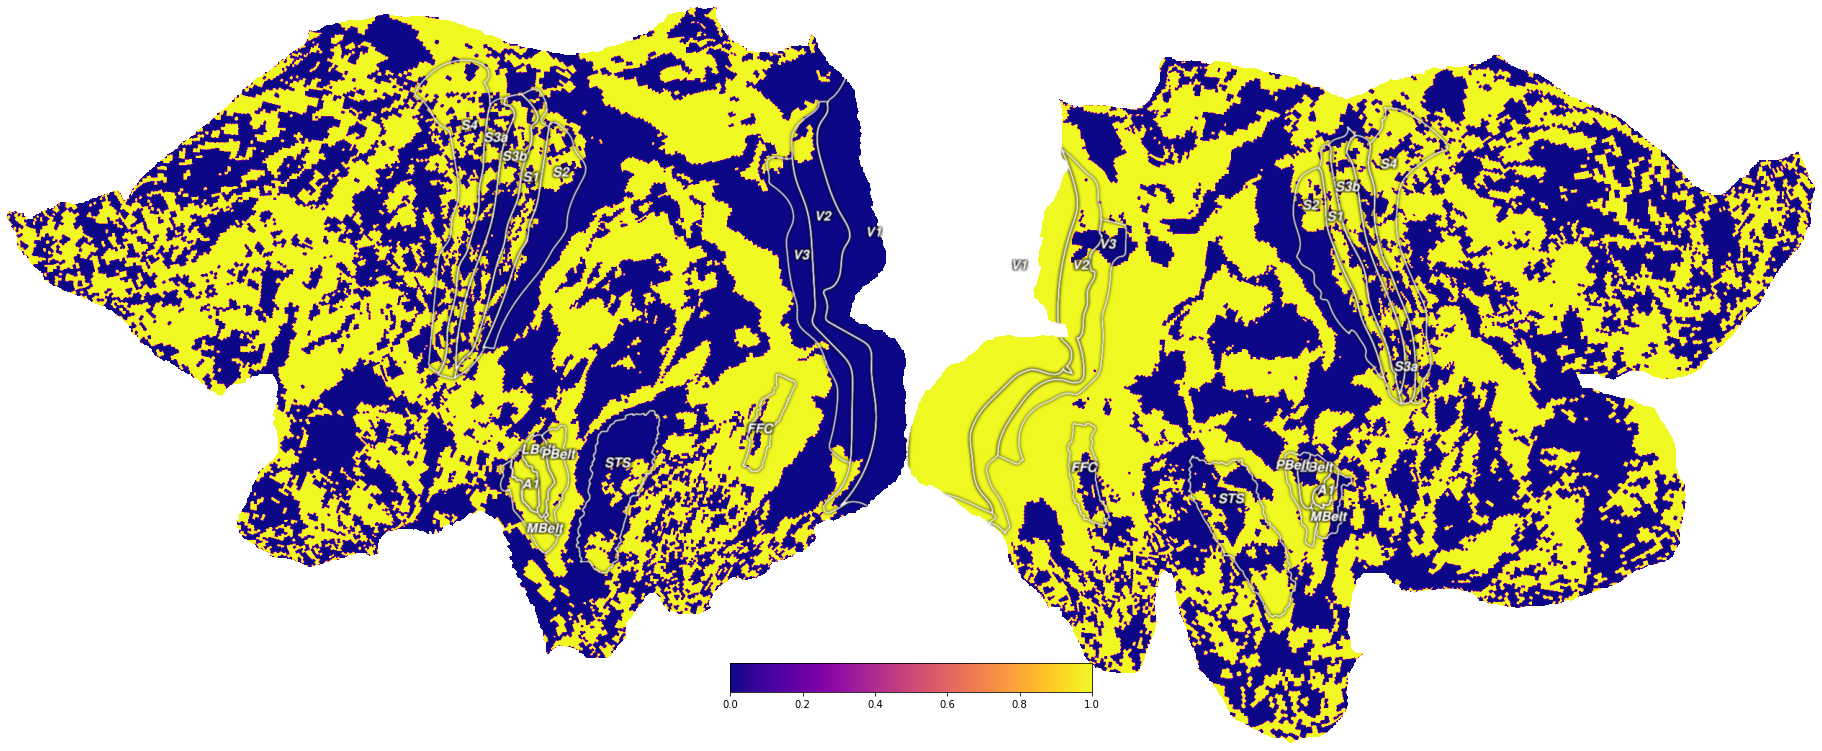

In [33]:
basic_plot(hem,vmax=1,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999')

Here, we can see that the left V2/V3 is best explained by the left V1 (blues) and the right V2/V3 is best explained by the right V1 (yellows).

The second column is the connective field size that best explains the vertex. We can plot this.

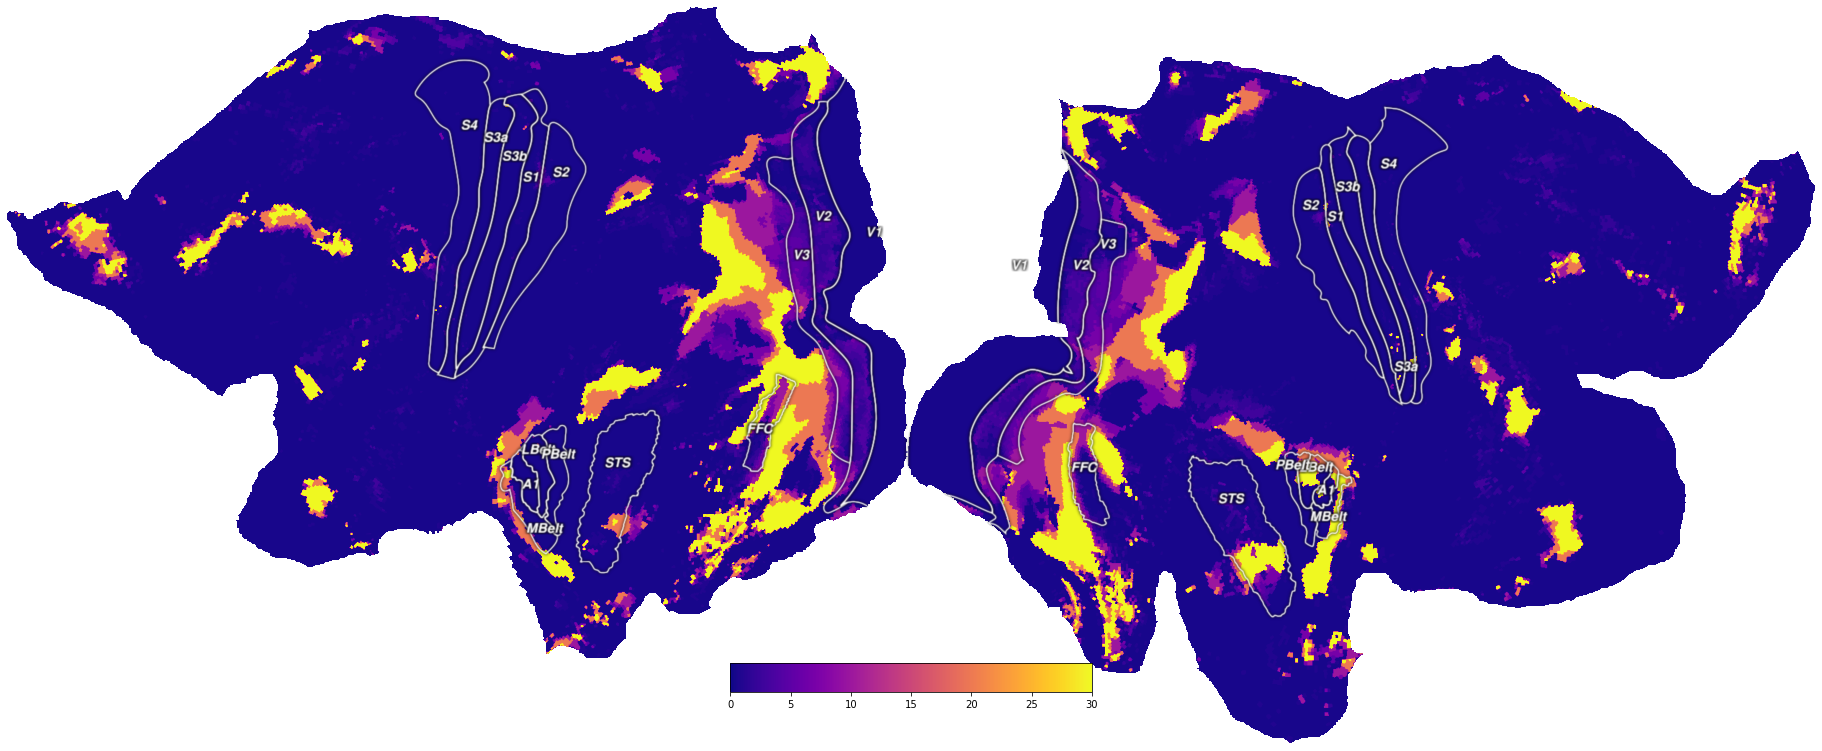

In [34]:
basic_plot(gf.quick_gridsearch_params[:,1],vmax=30,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999')

We see that the connective field sizes increase the more remote we get from V1.

The final column is the variance explained. 

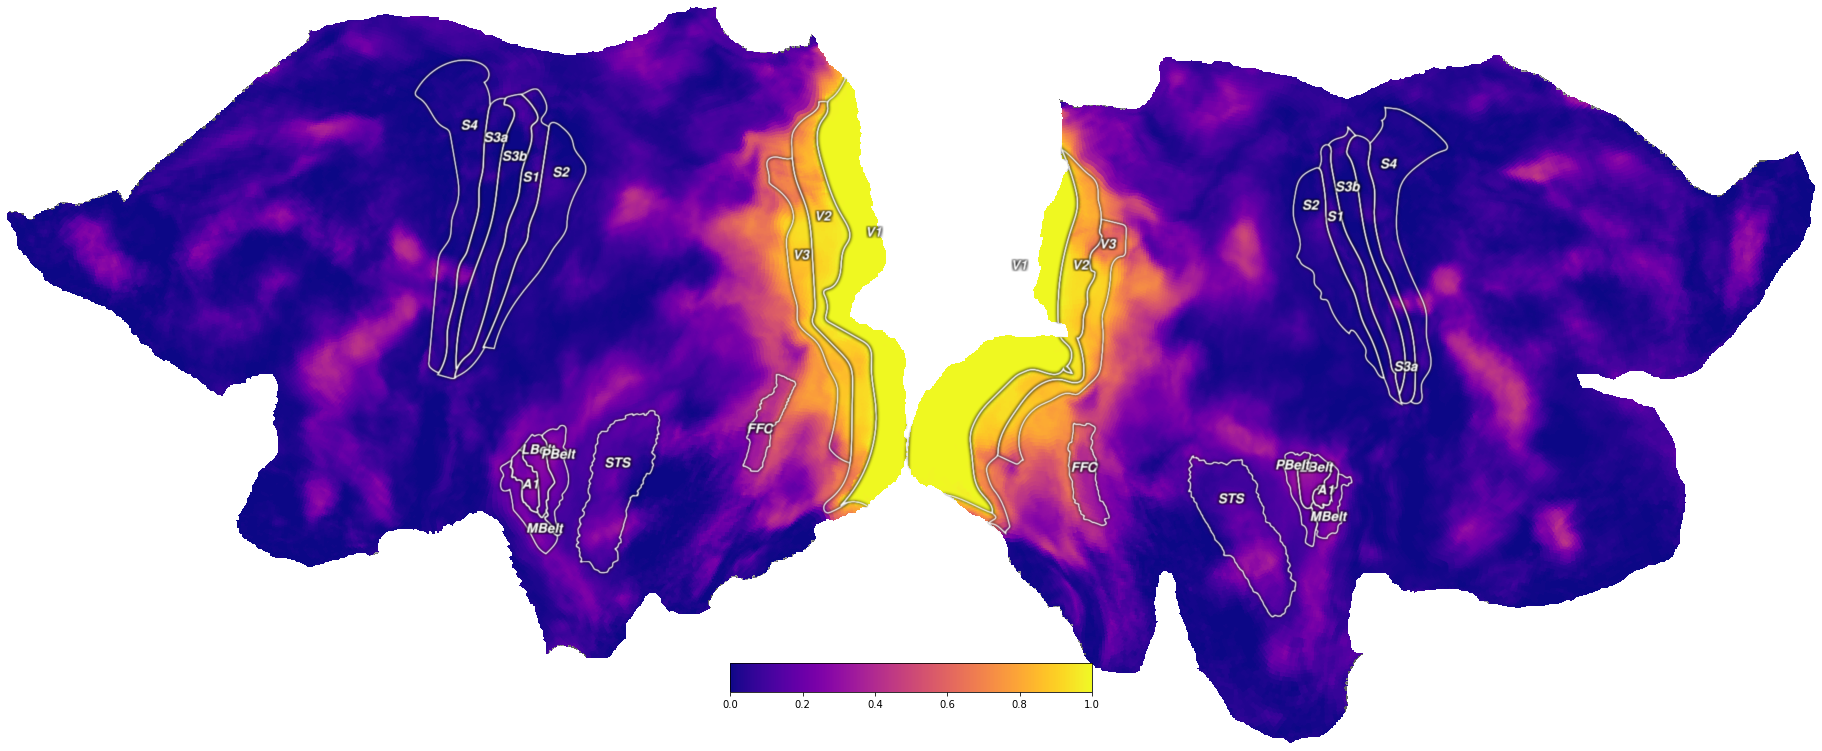

In [35]:
basic_plot(gf.quick_gridsearch_params[:,-1],vmax=1,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999')

We can use this variance explained data to enhance our visualisations and plot the estimated size weighted by the variance explained.

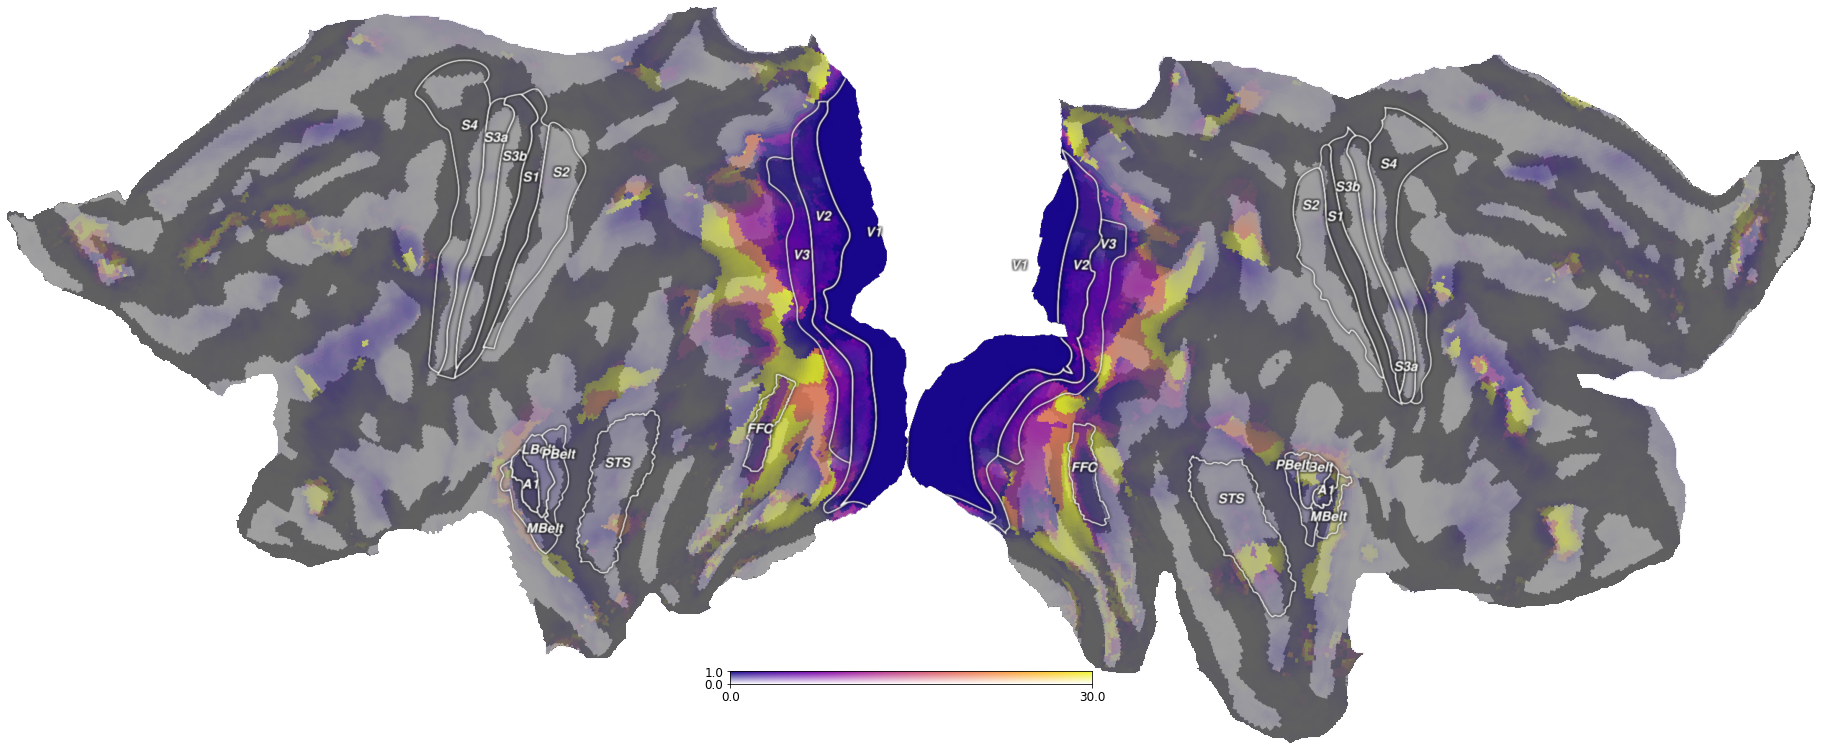

In [36]:
alpha_plot(gf.quick_gridsearch_params[:,1],gf.quick_gridsearch_params[:,-1],vmax=30,rois=True,cmap='plasma_alpha',colorbar=True,subject='hcp_999999')

Here, less reliable models appear as being more transparent on the flatmap.

## Stage 8. Perform cross-validation.

Now we can perform cross validation. For this, the only arguments are the test data and the test stimulus, both of which we created earlier on.

The way this works is to 

1. Create a new set of grid predictions - this time using the test design matrix. 
2. From this new set of predictions, select those with the parameters that provided the best fit to the training data.
3. Correlate these with the test data itself.

This therefore tests the ability of the fitted parameters to predict data that wasnt part of the training set.

In [37]:
gf.quick_xval(test_data=mydat_test,test_stimulus=test_stim)

/tank/hedger/software/anaconda3/envs/p3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [38]:
gf.xval_R2

array([ 0.01120465, -0.00508101,  0.00778946, ...,  0.1129214 ,
        0.12703287,  0.12994357])

Note that some of these values will be negative, indicating bad generalisation performance.

We can plot the training R2 and the test R2 as follows. 

/tank/hedger/software/anaconda3/envs/p3/lib/python3.8/site-packages/cortex/quickflat/composite.py:343: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar = fig.add_axes(colorbar_location)


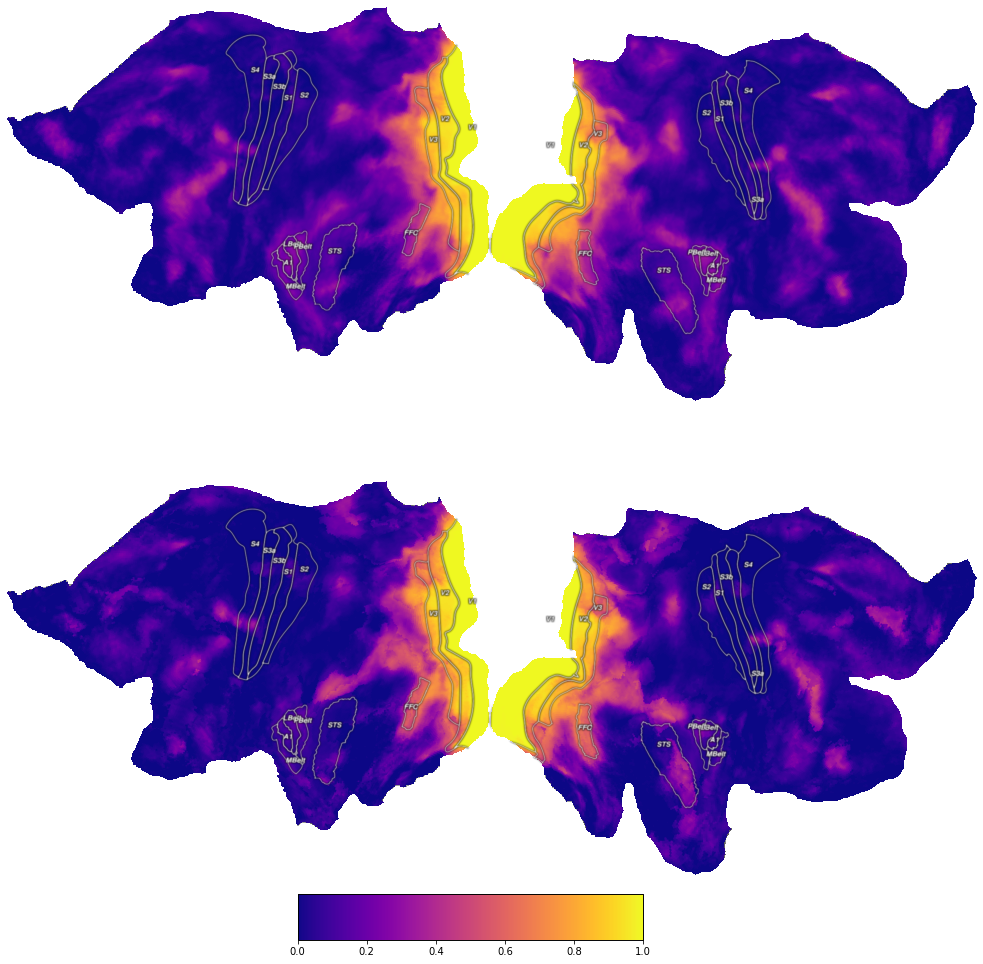

In [39]:
import matplotlib.pyplot as plt
full_figsize = (24, 16)
fig, axs = plt.subplots(2, 1, figsize=full_figsize)


basic_plot(gf.quick_gridsearch_params[:,-1],vmax=1,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999',ax=axs[0])
basic_plot(gf.xval_R2,vmax=1,rois=True,cmap='plasma',colorbar=True,subject='hcp_999999',ax=axs[1])

It's noticable that some of the regions more remote from V1 have poorer generalisation performance.